# **Impacto no uso de People Analytics em decisões organizacionais para identificação de talentos**

**Objetivo:** Este notebook objetiva apresentar os experimentos de um **Modelo de Classificação**, vinculado ao Trabalho de Conclusão de Curso para Data Science and Analytics, junto a USP-Esalq, utilizando a metodologia CRISP-DM, desde sua fase de Entendimento dos Dados à última etapa de Implantação. 

**Experimentos**: As testagens considerarão o uso de três modelagens: Regressão Logística, Árvore de Decisão e Random Forest. As escolhas destes algoritmos se deram justamente pela complementação entre eles, além da facilidade de uso e interpretabilidade dos modelos. A Regressão Logística é fácil de interpretar e mostra como cada variável impacta a chance de promoção. A Árvore de Decisão gera regras simples e visuais que facilitam entender as decisões. Já o Random Forest é mais robusto, melhorando a precisão e ajudando a evitar erros comuns em modelos mais simples. Desta forma, se torna possível analisar e comparar de forma clara a performance de cada um deles, auxiliando na escolha do modelo "vencedor".

**Link Dataset:** https://www.kaggle.com/datasets/bhrt97/hr-analytics-classification

*Para acessar a documentação do projeto, com os insights, instruções e resultados obtidos, acesse o arquivo README.md deste repositório*

## 📘 Dicionário de Variáveis

| Nome da Variável       | Significado                                                                                           |
|------------------------|-------------------------------------------------------------------------------------------------------|
| **matricula**          | Identificador único do(a) colaborador(a) na empresa.                                                  |
| **departamento**       | Departamento ou área em que o(a) colaborador(a) atua (ex: Vendas, Tecnologia, RH).                   |
| **regiao**             | Região geográfica de atuação do(a) colaborador(a) (sem ordem ou hierarquia específica).               |
| **escolaridade**       | Nível educacional alcançado pelo(a) colaborador(a) (ex: Graduação, Pós-graduação, etc.).             |
| **genero**             | Gênero do(a) colaborador(a), geralmente categorizado como "Masculino" ou "Feminino".                 |
| **canal_recrutamento** | Canal através do qual o(a) colaborador(a) foi recrutado(a) (ex: Recrutamento Interno, Agência).      |
| **qtd_treinamentos**   | Número de treinamentos (técnicos ou comportamentais) realizados no ano anterior.                      |
| **idade**              | Idade do(a) colaborador(a), em anos.                                                                  |
| **avaliacao_anterior** | Nota de desempenho atribuída ao(à) colaborador(a) no ano anterior (geralmente em uma escala de 1 a 5).|
| **tempo_empresa**      | Tempo de serviço na empresa, em anos completos.                                                       |
| **kpis_atingidos**     | Indicador binário: 1 se mais de 80% dos KPIs (indicadores de performance) foram atingidos; 0 caso contrário. |
| **premios**            | Indicador binário: 1 se o(a) colaborador(a) ganhou algum prêmio no ano anterior; 0 caso contrário.    |
| **media_treinamento**  | Nota média obtida nos treinamentos atuais (avaliações de desempenho nos cursos realizados).           |
| **promovido**          | Variável alvo (target): 1 se o(a) colaborador(a) foi recomendado(a) para promoção; 0 caso contrário.  |


## Importar Bibliotecas

In [1]:
# ============================================================
# 1. Importação de bibliotecas para manipulação dos dados e plots 
# ============================================================

import pandas as pd
import numpy as np

# ============================================================
# 2. Importação de bibliotecas relacionados à machine learning
# ============================================================

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from modulo_graficos import grafico_movimentacao_promovidos # Módulo Python (disponível no repositório do projeto)

In [2]:
# ============================================================
# 2. Ajustes visuais para visualização das tabelas e células
# ============================================================

pd.set_option('display.max_colwidth', None) # remover truncamento de valores das colunas
pd.set_option('display.max_rows', None) # remover truncamento do número de linhas exibidas
pd.set_option('display.max_columns', None) # remover truncamento do número de colunas exibidas
pd.set_option('display.float_format', '{:.2f}'.format) # valores quebrados serão setados com 2 casas decimais

## Input dos Dados

A base de dados disponibilizada pelo Kaggle está dividida em dois arquivos: treino e teste. 

Seguirei, portanto, a seguinte abordagem:

- A base de treino será utilizada para treinamento e validação do modelo (usando técnicas como validação cruzada ou divisão em treino/validação).
- A base de teste será utilizada apenas posteriormente para geração das previsões finais, pois seus rótulos são ocultos (avaliação cega).

A abordagem segue desta forma, pois visa garantir que o modelo não tenha acesso a dados do conjunto de teste durante o treinamento, evitando vazamento de informação e garantindo uma avaliação justa.

In [3]:
# ============================================================
# 3. Carregando base de dados e obtendo informações inicial dos dados
# ============================================================

df_treino = pd.read_csv("dataset/train_hr_class.csv")
df_teste = pd.read_csv("dataset/test_hr_class.csv")
print(f"DF Treino: {df_treino.shape}")
print(f"DF Teste: {df_teste.shape}")

DF Treino: (54808, 14)
DF Teste: (23490, 13)


In [4]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [5]:
df_treino.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.00,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.00,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.00,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.00,2,0,0,73,0


In [6]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPIs_met >80%         23490 non-null  int64  
 11  awards_won?           23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


In [7]:
df_teste.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.00,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.00,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.00,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.00,7,0,0,61


## Preparação dos Dados

### Tratamento e Limpeza dos Dados

Nesta seção, realizarei importantes etapas de tratamento de limpeza dos dados, tais como:

- Renomeio de colunas para Português-BR, a fim de facilitar a manipulação e compreensão dos dados
- Verificação de duplicidades
- Analisar o tipo dos dados, para eventuais conversões (caso necessário)
- Verificação de valores nulos e o seu devido tratamento

#### Renomear Variáveis

In [8]:
cols_treino = {"employee_id": "matricula", "department": "departamento", "region": "regiao", "education": "escolaridade",
               "gender": "genero", "recruitment_channel": "canal_recrutamento", "no_of_trainings": "qtd_treinamentos",
               "age": "idade", "previous_year_rating": "avaliacao_anterior", "length_of_service": "tempo_empresa",
               "KPIs_met >80%": "kpis_atingidos", "awards_won?": "premios", "avg_training_score": "media_treinamento",
               "is_promoted": "promovido"}

cols_teste = {"employee_id": "matricula", "department": "departamento", "region": "regiao", "education": "escolaridade",
              "gender": "genero", "recruitment_channel": "canal_recrutamento", "no_of_trainings": "qtd_treinamentos",
              "age": "idade", "previous_year_rating": "avaliacao_anterior", "length_of_service": "tempo_empresa",
              "KPIs_met >80%": "kpis_atingidos", "awards_won?": "premios", "avg_training_score": "media_treinamento"}

df_treino = df_treino.rename(columns=cols_treino)
df_teste = df_teste.rename(columns=cols_teste) # subconjunto dos nomes para o DF Teste não tem a variável target (promovido)
df_treino.head(1)

,matricula,departamento,regiao,escolaridade,genero,canal_recrutamento,qtd_treinamentos,idade,avaliacao_anterior,tempo_empresa,kpis_atingidos,premios,media_treinamento,promovido
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0


#### Duplicidade

In [9]:
if df_treino['matricula'].duplicated().any():
    print("Existem duplicados")
else:
    print("Não há matrículas duplicadas")

Não há matrículas duplicadas


#### Tipologia dos Dados

In [10]:
def tratar_tipo_dados(df):
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except ValueError:
            pass
        except TypeError:
            print(f"Não foi possível converter a coluna {col} devido a um TypeError.")
        # Abaixo, converte colunas do tipo 'object' para 'category' se menos de 30% dos valores forem únicos
        if df[col].dtype == 'object' and df[col].nunique() / len(df) < 0.3: 
            df[col] = df[col].astype('category')

        # Temos variáveis que são binárias, neste caso, forçaremos a conversão delas para categóricas
        lista_colunas = ['kpis_atingidos', 'premios', 'promovido']
        for col in lista_colunas:
            if col in df.columns:
                df[col] = df[col].astype('category')
    return df

df_treino = tratar_tipo_dados(df_treino)

In [11]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   matricula           54808 non-null  int64   
 1   departamento        54808 non-null  category
 2   regiao              54808 non-null  category
 3   escolaridade        52399 non-null  category
 4   genero              54808 non-null  category
 5   canal_recrutamento  54808 non-null  category
 6   qtd_treinamentos    54808 non-null  int64   
 7   idade               54808 non-null  int64   
 8   avaliacao_anterior  50684 non-null  float64 
 9   tempo_empresa       54808 non-null  int64   
 10  kpis_atingidos      54808 non-null  category
 11  premios             54808 non-null  category
 12  media_treinamento   54808 non-null  int64   
 13  promovido           54808 non-null  category
dtypes: category(8), float64(1), int64(5)
memory usage: 2.9 MB


#### Nulos

In [12]:
df_treino.isnull().sum()[df_treino.isnull().sum() > 0]

escolaridade          2409
avaliacao_anterior    4124
dtype: int64

In [13]:
df_treino['escolaridade'].value_counts()

escolaridade
Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: count, dtype: int64

In [14]:
df_treino['avaliacao_anterior'].value_counts()

avaliacao_anterior
3.00    18618
5.00    11741
4.00     9877
1.00     6223
2.00     4225
Name: count, dtype: int64

**Para este tratamento de dados, optarei pela imputação de valores fixos:**
- Avaliação Anterior: para quem não teve nota computada para avaliação anterior, igualaremos à zero (0)
- Escolaridade: para quem não tem registro sobre o nível de escolaridade, preencheremos com "No_Education"

In [15]:
df_treino['escolaridade'] = df_treino['escolaridade'].cat.add_categories(['No_Education'])
df_treino['escolaridade'] = df_treino['escolaridade'].fillna('No_Education')
df_treino['avaliacao_anterior'] = df_treino['avaliacao_anterior'].fillna(0)

In [16]:
df_treino.isnull().sum()[df_treino.isnull().sum() > 0]

Series([], dtype: int64)

In [17]:
# Separar features e target do treino
X = df_treino.drop(["promovido", "matricula"], axis=1)
y = df_treino["promovido"]

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

# Função para tratar as variáveis específicas
def tratar_variaveis(df):
    df = df.copy()
    # Escolaridade
    if df['escolaridade'].dtype.name == 'category':
        if 'No_Education' not in df['escolaridade'].cat.categories:
            df['escolaridade'] = df['escolaridade'].cat.add_categories(['No_Education'])
    df['escolaridade'] = df['escolaridade'].fillna('No_Education')
    # Avaliação anterior
    df['avaliacao_anterior'] = df['avaliacao_anterior'].fillna(0)
    return df

# Aqui atuamos com essa transformação específica
tratamento_custom = FunctionTransformer(tratar_variaveis)

# Separando Colunas categóricas e numéricas
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipelines numérico e categórico
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Pré-processamento geral
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Pipeline final com tratamento customizado antes
pipeline_final = Pipeline(steps=[
    ("tratamento_custom", tratamento_custom),
    ("preprocessor", preprocessor)
])

# Exemplo de uso
pipeline_final.fit(X, y)
X_transformed = pipeline_final.transform(X)

In [27]:
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced")
}

for nome, modelo in modelos.items():
    pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", modelo)
    ])
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring="recall")
    print(f"{nome} - Recall médio (CV): {scores.mean():.4f}")

Regressão Logística - Recall médio (CV): 0.8160
Árvore de Decisão - Recall médio (CV): 0.4505
Random Forest - Recall médio (CV): 0.2948


# Tentativa 2

In [31]:
!pip install imblearn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   --------------------------------- ------ 9.4/11.1 MB 45.2 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 36.6 MB/s  0:00:00

  Attempting uninstall: scikit-learn

    Found existing installation: scikit-learn 1.7.1

   ---------------------------------------- 0/4 [scikit-learn]
   ---------------------------------------- 0/4 [scikit-learn]
   ---------------------------------------- 0/4 [scikit-learn]
   ---------------------------------------- 0/4 [scikit-learn]
   ---------------------------------------- 0/4 [scikit-learn]
   ---------------------------------------- 0/4 [scikit-learn]
   ---------------------------------------- 0/4 [scikit-learn]
   ---------------------------------------- 0/4 [scikit-learn]
   ---------------------------------------- 0/4 [scikit-learn]
   ---------------------------------------- 0/4 [scikit-learn]
   ---------------------------------------- 0/4 [sciki

  You can safely remove it manually.


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay, recall_score
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import auc, precision_recall_curve, fbeta_score
import optuna
from pickle import dump

ModuleNotFoundError: No module named 'imblearn'

In [30]:
# Função SCORE

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)

def print_score(real,pred,proba):
    df_score = pd.DataFrame(classification_report(real, pred, output_dict=True))
    recall = recall_score(y_test, y_pred)
    print(f'\nRecall: {recall}',flush=True)
    precision_curve, recall_curve, _ = precision_recall_curve(real, proba)
    aucpr = auc(recall_curve, precision_curve)
    print(f'AUCPR: {aucpr}',flush=True)
    f2_score = fbeta_score(real, pred.round(), beta=2)
    print(f'F2 Score: {f2_score}',flush=True) 
    #print(df_score, flush=True)
    cm = confusion_matrix
    cm = confusion_matrix(real, pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['não-promovido','promovido'])
    cmd.plot()
    return df_score

In [28]:
# Definindo o objetivo da função
def objective(trial):

    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard'])
 
    # Definir escaladores de padronização (standard) ou normalização (minmax)
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()

        # Instanciando o modelo
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2,800,step=2)
    max_leaf_nodes =  trial.suggest_int('max_leaf_nodes',2,2000,step=5)
    min_samples_split = trial.suggest_int('min_samples_split',2,6)
    estimator = DecisionTreeClassifier(criterion=criterion,
                                       max_depth=max_depth, 
                                       max_leaf_nodes=max_leaf_nodes, 
                                       min_samples_split=min_samples_split)
                                                        
    # Pipeline do modelo
    pipeline = make_pipeline(scaler, estimator)
    rus = RandomUnderSampler(random_state=42)
    x,y = rus.fit_resample(X_train, y_train)
    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, x, y, scoring='accuracy')   
    return score.mean()

if __name__ == '__main__':

    X_train = pd.read_csv("X_train_ng_custom.csv", header=0)
    X_test = pd.read_csv("X_test_ng_custom.csv", header=0)
    
    y_train = X_train['IN_CMST_FUN'].reset_index(drop=True)
    y_test = X_test['IN_CMST_FUN'].reset_index(drop=True)
    
    X_train.drop(columns=['IN_CMST_FUN'], inplace=True)
    X_test.drop(columns=['IN_CMST_FUN'], inplace=True)
    
    study = optuna.create_study(direction="maximize") # maximise the score during tuning
    study.optimize(objective, n_trials=200, n_jobs=-1) # run the objective function 100 times

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

FileNotFoundError: [Errno 2] No such file or directory: 'X_train_ng_custom.csv'

#### Estatística Descritiva

In [ ]:
df_treino.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T.drop('matricula', errors='ignore')

#### Proporção da variável target/alvo

In [ ]:
df_treino['promovido'] = df_treino['promovido'].astype(int).astype('category')
df_treino['promovido'].value_counts()

#### Análise das variáveis numéricas

In [ ]:
# Distribuição das variáveis numéricas, exceto a variável matricula, visto que é um ID (identificador)

num_cols = df_treino.select_dtypes(include=['int64', 'float64']).columns.drop('matricula')
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df_treino[col], kde=True)
    plt.title(f"Distribuição - {col}")
    plt.ylabel("Quantidade")
    plt.show()

**Percebi que as variáveis kpis_atingidos e premios, indicam "verdadeiro" ou "falso", apesar de seus valores possíveis serem inteiros (1 ou 0). Vamos confirmar abaixo e se for verdadeiro, transformaremos para variáveis categóricas.**


In [ ]:
print(df_treino['kpis_atingidos'].unique())
print(df_treino['premios'].unique())

**Dado a confirmação da hipótese apresentada nas visualizações gráficas, transformaremos as variáveis para categóricas**

In [ ]:
df_treino['kpis_atingidos'] = df_treino['kpis_atingidos'].astype('category')
df_treino['premios'] = df_treino['premios'].astype('category')

In [ ]:
df_treino.info()

In [ ]:
# Após as transformações, ploto novamente os gráficos de histogramas e agora acrescento também com o boxplot

num_cols = df_treino.select_dtypes(include=['int64', 'float64']).columns.drop('matricula')
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df_treino[col], kde=True)
    plt.title(f"Distribuição - {col}")
    plt.ylabel("Quantidade")
    plt.show()

In [ ]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_treino[col])
    plt.title(f"Boxplot - {col}")
    plt.xlabel(col)
    plt.show()

In [ ]:
# Para algumas variáveis numéricas (principalmente relacionadas a desempenhos), quero analisar a distribuição
# Considerando a proporção de Promovidos x Não Promovidos

num_cols = df_treino.select_dtypes(include=['int64', 'float64']).columns.drop(['matricula', 'idade', 'tempo_empresa'])
for col in num_cols:
    grafico_movimentacao_promovidos(df_treino, col, tipo='histograma')

In [ ]:
df_treino['qtd_treinamentos'].value_counts(normalize=True)*100

In [ ]:
df_treino[(df_treino["qtd_treinamentos"]==1) | (df_treino["qtd_treinamentos"]==2)]['promovido'].value_counts()

In [ ]:
# promovidos para qtd_treinamentos = 1 ou 2
prom_qtd_treinamento = df_treino[((df_treino["qtd_treinamentos"] == 1) | (df_treino["qtd_treinamentos"] == 2)) & 
          (df_treino["promovido"] == 1)]['matricula'].count()
total_promovidos = df_treino[df_treino["promovido"]==1]['matricula'].count()
result = (prom_qtd_treinamento/total_promovidos)*100
print(np.round(result, 2))

**No caso da variável de nota média de treinamento, criarei faixas para facilitar a visualização e interpretação dos dados**

- Faixas: começando a partir de 30 e intervalando a cada 10 pontos

In [ ]:
# Faixas de notas médias (com intervalo de 10 pontos)
bins = range(30, 101,10)
labels = [f"{b}-{b+9}" for b in bins[:-1]]
df_treino['faixa_treinamento'] = pd.cut(df_treino['media_treinamento'], bins=bins, labels=labels, right=False)

# Garantir que promovido seja numérico
df_treino['promovido'] = df_treino['promovido'].astype(int)

# Calcular taxa de promoção por faixa
taxa_promocao = df_treino.groupby('faixa_treinamento', observed=True)['promovido'].mean() * 100
contagem = df_treino.groupby('faixa_treinamento', observed=True)['promovido'].count()

# Plotar
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras: taxa de promoção
ax1.bar(taxa_promocao.index, taxa_promocao, color='skyblue', alpha=0.8)
ax1.set_ylabel('Funcionários Promovidos %', fontsize=14)
ax1.set_xlabel('Faixas das Notas Médias de Treinamento', fontsize=14)
ax1.set_title('Taxa de Promovidos por Notas Médias de Treinamento', fontsize=16)
ax1.set_ylim(0, 100)

# Adicionar rótulos
for i, val in enumerate(taxa_promocao):
    ax1.text(i, val + 1, f"{val:.1f}%", ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Anotações sobre as análises gráficas dos dados numéricos**
- Em relação ao número de treinamentos (técnicos ou comportamentais), a grande maioria possuí apenas a realização de 1 treinamento (81% aproximadamente), com 96% tendo realizado até 2 treinamentos no ano anterior. Quanto aos promovidos, para quem realizou 1 treinamento, aproximadamente 9,7% receberam promoção no último ano e cerca de 8,2% dos que realizaram 2 treinamentos, foram promovidos. Quando olhamos apenas para esses dois grupos 9,43% foram promovidos e para o total geral representam quase 97% dos promovidos. Assim sendo, aparentam que ter muitos cursos, para este caso, não resultam em promoções.
- No caso da avaliação anterior, temos 339 colaboradores que tiveram nota = 0 no ano anterior e foram promovidos, me parece que essa atribuição não seria o resultado em si, mas o fato de não ter avaliação registrada. Podemos ver que a performance dos promovidos é crescente, conforme o aumento das notas no ano anterior, melhor representado na tabela e gráfico, abaixo:

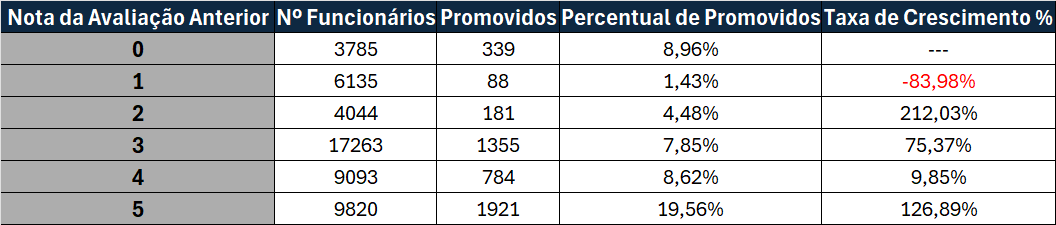

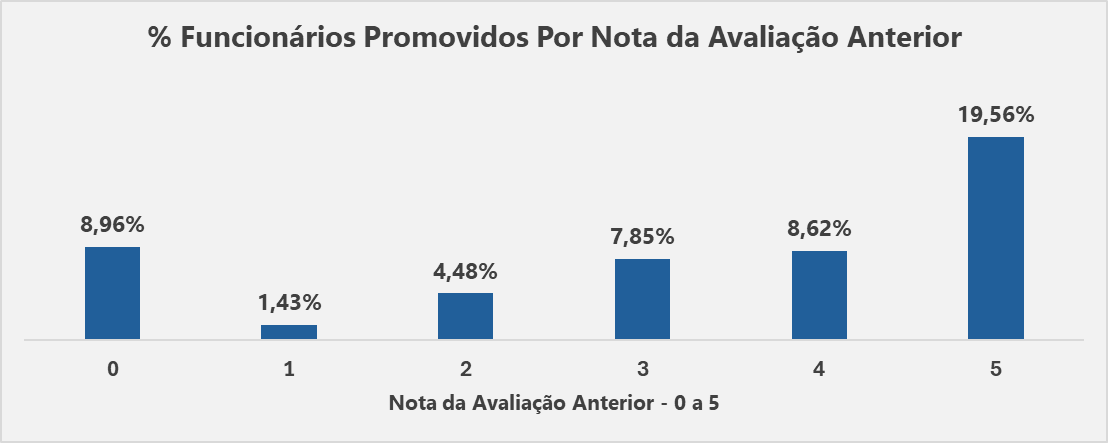

- Quanto ao gráfico que analisa a taxa de proporção por nota média de treinamento, podemos identificar que há um aproveitamento extremamente superior para os funcionários que atingem a meta superior aos 90 pontos de nota. As demais faixas, apresentam valores em um intervalo próximo de aproveitamento, variando entre 3,9% para a menor pontuação do intervalo (40 a 49) e 11,7% de aproveitamento para a maior pontuação do intervalo (80 a 89), excluindo, obviamente, a faixa de pontuação máxima (90 a 99).

#### Análise das variáveis categóricas

In [ ]:
# Distribuição das variáveis categóricas, considerando a distribuição PROMOVIDOS

cat_cols = df_treino.select_dtypes(include=['category']).columns.drop('regiao')
for col in cat_cols:
    grafico_movimentacao_promovidos(df_treino, col, tipo='barras_agrupadas')

In [ ]:
grafico_movimentacao_promovidos(df_treino, 'genero', tipo='taxa_promocao')

In [ ]:
df_kpis_premios = df_treino.query('kpis_atingidos == 1 & premios == 1')
print(df_kpis_premios.shape[0])

In [ ]:
df_kpis_premios['promovido'].value_counts()

**Anotações sobre as análises gráficas das variáveis categóricas**

- Quando analisamos a Taxa de Conversão dos Departamentos, ou seja, o percentual de aproveitamento dos departamentos, temos uma taxa de conversão média (aproximada) de 8,73% de promoção, assim sendo, 5 departamentos ficaram acima desta média: Analytics, Finance, Operations, Procurement e Technology, conforme gráfico abaixo:

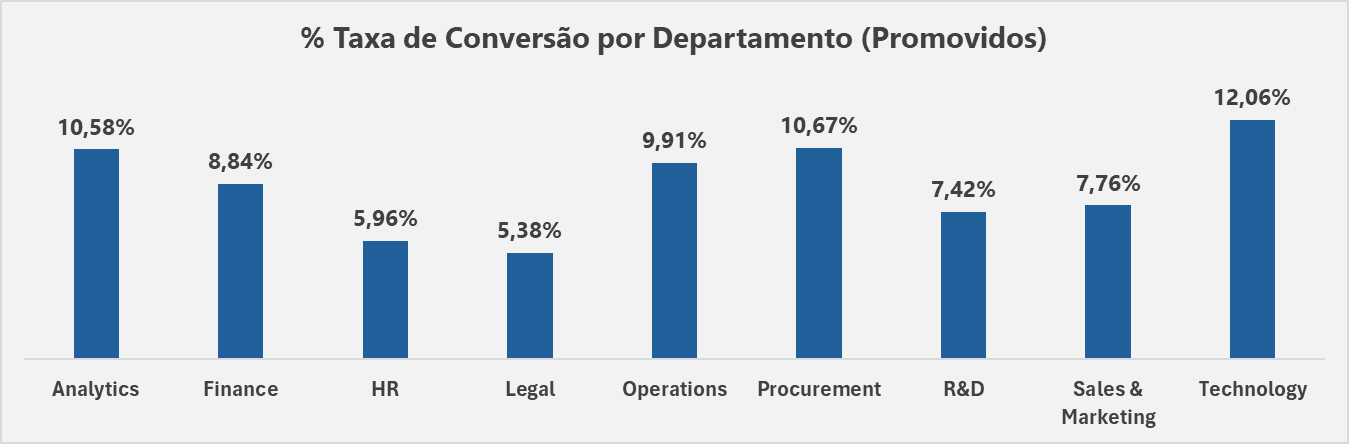

- Em relação ao nível de escolaridade, as correspondências são:  	
| Nome da Variável       | Significado                                                                                           |
|------------------------|-------------------------------------------------------------------------------------------------------|
| **Below Secondary**          | Abaixo do Ensino Médio                                                  |
| **Bachelor's**          | Ensino Superior – Graduação                                                  |
| **Master's & Above**          | Pós-graduação (Mestrado, Doutorado)                                    |
| **No_Education**          | Sem Escolaridade                                                           |
- Assim sendo, o gráfico abaixo demonstra a Taxa de Conversão por **Escolaridade**, mostrando também uma distribuição bastante semelhante entre os três principais níveis, com uma queda mais contundente para os que não possuem nenhum grau de escolaridade
- O percentual por **gênero** demonstra uma distribuição geral de aproximadamente 70 a 30%, com predominância do gênero masculino. No entanto, na avaliação dos promovidos, o gênero feminino tem uma leve predominância com taxa de conversão igual a 9%, enquanto o masculino com 8,3%. Assim, se considerarmos a proporção individual, o gênero feminino possuí uma taxa maior em conversão.
- Em relação as variáveis de desempenho como **kpis_atingidos** (que aponta que o colaborado no ano anterior, alcançou pelo menos 80% dos kpi's voltados aos indicadores de perfomance) e **premios** (que aponta se o colaborador recebeu alguma premiação no ano anterior), vemos que há uma taxa de conversão superior para os funcionários que possuem esses indicadores, sendo aproximadamente 20% para kpis_atingidos e 78% para aqueles que receberam premiação. Quando juntamos os funcionários que possuem kpis atingidos e premiação, essa taxa fica em aproximadamente 63% de taxa de promoção.

#### Análise de Correlação

In [ ]:
# Correlação numérica com o target
num_cols = df_treino.select_dtypes(include=['int64', 'float64']).columns.drop(['promovido', 'matricula'])
corr = df_treino[num_cols].corrwith(df_treino['promovido'])
print(corr.sort_values(ascending=False))

In [ ]:
num_cols = df_treino.select_dtypes(include=['int64', 'float64']).columns
correlacao = df_treino[num_cols].corr()

# Depois disso, crio um heatmap da correlação, que seria a plotagem dessa matriz
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre variáveis")
plt.show()

In [ ]:
# Correlação apenas com a target

corr_df = corr.to_frame(name='Correlação com promovido')
plt.figure(figsize=(8, len(corr_df) * 0.5))
sns.heatmap(corr_df.sort_values(by='Correlação com promovido', ascending=False), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre variáveis numéricas e o target (promovido)')
plt.show()

Para análise que investiga a correlação estatística entre as variáveis, nenhuma correlação à nível negocial que possa impactar em caráter preditivo. Há uma correlação natual existente entre **"idade"** e **"tempo_empresa"**, que no entanto, não agrega valor ao negócio, para o que estamos querendo prever/analisar.

#### Análise - Teste de Associação (qui-quadrado)

In [ ]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Seleciona colunas categóricas
cat_cols = df_treino.select_dtypes(include=['object', 'category']).columns

# Codifica as variáveis categóricas
df_cat = df_treino[cat_cols].copy()
for col in df_cat.columns:
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col].astype(str))

# Aplica o teste qui-quadrado
chi_scores, p_values = chi2(df_cat, df_treino['promovido'])

# Cria DataFrame com os resultados
chi2_df = pd.DataFrame({
    'Variavel': df_cat.columns,
    'Qui-Quadrado': chi_scores,
    'p-valor': p_values
}).sort_values(by='Qui-Quadrado', ascending=False)

print(chi2_df)

# Gráfico (barra)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Qui-Quadrado', y='Variavel', data=chi2_df)
# Colocar valores das barras dentro delas
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width + 0.5, y, f'{width:.1f}', va='center')
plt.title('Importância das variáveis categóricas pelo teste Qui-Quadrado')
plt.xlabel('Coeficiente (Estatística Qui-Quadrado)')
plt.ylabel('')
plt.tight_layout()
plt.show()

Em relação ao teste de associação, conforme já havíamos registrado anteriormente, variáveis como **premios**, **kpis_atingidos** demonstraram uma alta associação com o target. Assim, podemos concluir que funcionários que receberam prêmios e tiveram atingimento de pelo menos 80% dos kpi's de indicadores de performance, apresentam maior proporção de promoção em comparação aos que não receberam


Lembrando que a variável de **faixa de treinamento** foi criada apenas para demonstrar intervalos de notas médias que os colaboradores alcançaram, na qual identificamos que quanto maior a faixa, maior a conversão da promoção, por isso apresenta um coeficiente alto de associação qui-quadrado